In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Для запуска графического ядра
import time

def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print(" какой GPU:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

 CPU работает:
100 циклов: 355.32ms
 какой GPU:
100 циклов: 372.91ms
 CPU работает:
100 циклов: 357.32ms
 какой GPU:
100 циклов: 6.01ms


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, Flatten, LSTM,Conv1D,MaxPooling1D
from sklearn.preprocessing import StandardScaler


In [3]:
def testing(model,num_iter):
    start = time.time()
    res=[]
    res_tr=[]
    for _ in range(num_iter):
        model.set_weights(ww)
        hh = model.fit(x=train_x,y=train_y, epochs=epochs,\
                       batch_size=batch_size, validation_data=(test_x, test_y), verbose=0)
        res.append(hh.history['val_mae'][-1])
        res_tr.append(hh.history['mae'][-1])
    res = np.array(res)
    
    d={'epochs':epochs,
        'res_max' : res.max(),
        'res_min' : res.min(),
        'res_mean' : res.mean(),
        'res_std' : res.std(),
       'batch_size':batch_size,
       'res_train_mean':np.array(res_tr).mean(),
       'time_iter': (time.time() - start)/num_iter
    }    
    
    return d

In [4]:
df = pd.read_csv('airline-passengers.csv')

In [5]:
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [6]:
train_split = 100
x_train= df[:train_split]
x_test = df[train_split:]


<AxesSubplot:>

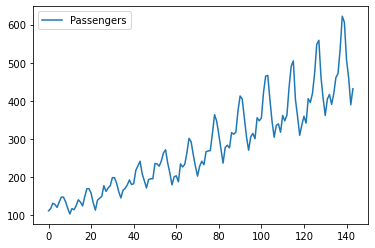

In [7]:
df.plot()

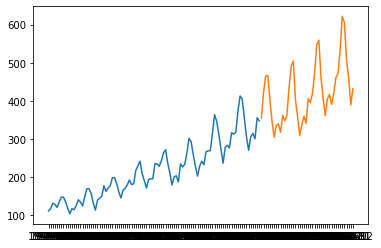

In [8]:
plt.plot(x_train['Month'],x_train['Passengers'])
plt.plot(x_test['Month'],x_test['Passengers'])
plt.show()

In [9]:
ss = StandardScaler()
ss.fit(x_train[['Passengers']])
train = ss.transform(x_train[['Passengers']])
valid = ss.transform(x_test[['Passengers']])

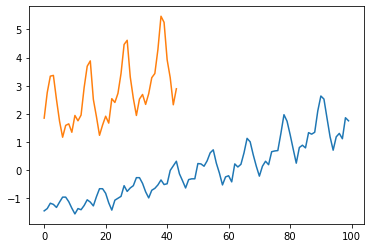

In [10]:
plt.plot(train)
plt.plot(valid)
# plt.plot(x_train['Month'],x_train['Passengers'])
# plt.plot(x_test['Month'],x_test['Passengers'])
plt.show()

In [11]:
# шаг по данным для построения обучающих примеров
step = 1
xLen = 3
# длина прошлого 


In [12]:
def num_iter(n_len,xLen,step):
    z = n_len//step
    y = n_len%step
    while y<xLen+1:
        z-=1
        y+=step
    return z+1
    

In [13]:
def get_data(data,xLen,step):
    x=[]
    y=[]
    num_it = num_iter(len(data),xLen,step)
    for i in range(num_it):
        x.append(data[i*step:i*step+xLen])
        y.append(data[i*step+xLen])
    x = np.array(x)    
    return x.reshape(-1,xLen,1),np.array(y)    

In [22]:
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a*b).mean()
    sa = a.std()
    sb = b.std()
  
    val = 0
    if ((sa>0) & (sb>0)):
        val = (mab-ma*mb)/(sa*sb)
    return val

In [54]:
def print_corr(yVal,yPredVal,start=0,step=20):
    corr = []
    yLen = yVal.shape[0]
    yValF = yVal[start:start+step].flatten()
    yPredVal = predVal[start:start+step]
    for i in range(1,10):
        corr.append(correlate(yValF[:-i], yPredVal[i:]))
    plt.plot(corr, 
             label='Корреляция')
    plt.xlabel('Время')
    plt.ylabel('Значение Close')
    plt.legend()
    plt.show()
    return corr

In [14]:
xLen = 5
train_x,train_y = get_data(data = x_train.Passengers.to_numpy(),xLen=xLen,step=step)
test_x,test_y = get_data(data = x_test.Passengers.to_numpy(),xLen=xLen,step=step)

In [15]:
xLen = 6
train_x,train_y = get_data(data = train,xLen=xLen,step=step)
test_x,test_y = get_data(data = valid,xLen=xLen,step=step)

In [16]:
input_1 = Input(shape=(train_x.shape[1:]))
z1 = Conv1D(24,6,padding = 'same')(input_1)
z1=MaxPooling1D(pool_size = 12,strides =1,padding = 'same')(z1)
z1 = Dropout(0.2)(z1)

x1 = LSTM(64, return_sequences="True")(z1)
x1 = Dropout(0.2)(x1)

x1=Flatten()(x1)
x1 = Dense(300,activation='relu')(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(100,activation='relu')(x1)
x1 = Dropout(0.2)(x1)
out=Dense(1)(x1)
model = Model(inputs = input_1,outputs = out,name = 'model')
model.compile(loss="mse", optimizer="adam", metrics=['mae'])
model.summary()
ww= model.get_weights()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 24)             168       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 24)             0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 24)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 64)             22784     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0     

In [17]:
model.set_weights(ww)
history = model.fit(x=train_x,y=train_y, epochs=100,\
                       batch_size=35, validation_data=(test_x, test_y), verbose=1)


Epoch 1/100
3/3 [==============================] - 3s 183ms/step - loss: 0.7524 - mae: 0.7008 - val_loss: 3.4761 - val_mae: 1.5434
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.3079 - mae: 0.4204 - val_loss: 1.1537 - val_mae: 0.9096
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 0.3579 - mae: 0.4787 - val_loss: 1.0937 - val_mae: 0.8993
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2992 - mae: 0.4322 - val_loss: 1.3140 - val_mae: 0.8704
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.2461 - mae: 0.3948 - val_loss: 2.0636 - val_mae: 1.1393
Epoch 6/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2882 - mae: 0.4279 - val_loss: 2.0923 - val_mae: 1.1709
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 0.2206 - mae: 0.3502 - val_loss: 1.4078 - val_mae: 0.9192
Epoch 8/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1995 - mae: 0.3

3/3 [==============================] - 0s 13ms/step - loss: 0.0885 - mae: 0.2331 - val_loss: 0.3592 - val_mae: 0.4863
Epoch 64/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0658 - mae: 0.2034 - val_loss: 0.5440 - val_mae: 0.6049
Epoch 65/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0795 - mae: 0.2198 - val_loss: 0.4505 - val_mae: 0.5490
Epoch 66/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0660 - mae: 0.1995 - val_loss: 0.2951 - val_mae: 0.4322
Epoch 67/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0625 - mae: 0.2002 - val_loss: 0.2730 - val_mae: 0.4130
Epoch 68/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0689 - mae: 0.2001 - val_loss: 0.6743 - val_mae: 0.6885
Epoch 69/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0760 - mae: 0.2215 - val_loss: 0.8902 - val_mae: 0.7935
Epoch 70/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0685 - mae: 0.2103 - 

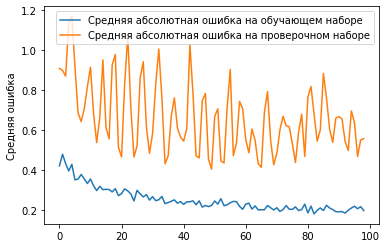

In [18]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [19]:
predVal = model.predict(test_x).flatten()

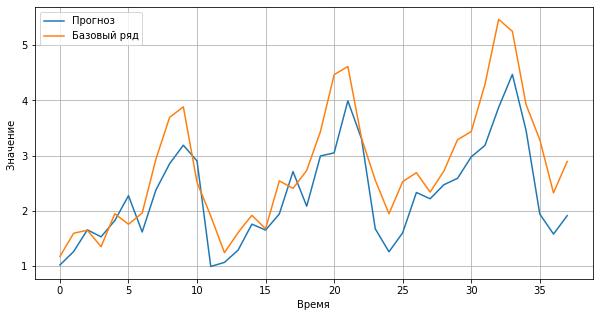

In [20]:
# Не нормалтзованные данне
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

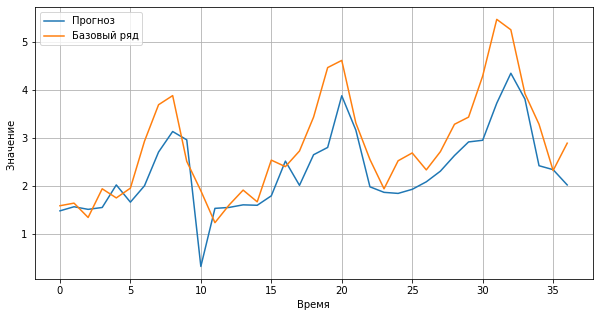

In [400]:
# Нормализованные данные
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [21]:
%%time
N=300
res_model = pd.DataFrame()
epochs = 100
batch_size = None
xLen = [2,3,4,5,6,8,10,12]
step=[1,1,1,1,1,2]
con_n = [6,12,24,30,36,48,64,124]   
kern = [2,3,4,5,6,7,8,9,10,11,12]
ps = [2,3,4,5,6,7,8,9,10,11,12]
lstm_n = [12,24,36,48,60,72,80,100]
d_n_1 = [10,25,35,45,50,60,70,80,90,100,15,200,300,350,400,500]
act_1 = ['relu','relu','softmax','relu','relu','tanh','relu','relu']
dp=[0.1,0.15,0.2,0.2,0.3]


for i in range(N):
    param={}

    param['xLen'] = np.random.choice(xLen)
    param['step'] = np.random.choice(step)
    param['con_n'] = np.random.choice(con_n)
    param['kern'] = int(np.random.choice(kern))
    param['ps'] = int(np.random.choice(ps))
    param['d_n_1'] = np.random.choice(d_n_1)
    param['d_n_2'] = np.random.choice(d_n_1)
    param['act_1'] = np.random.choice(act_1)
    param['act_2'] = np.random.choice(act_1)
    param['lstm_n'] = np.random.choice(lstm_n)
    param['dp'] = np.random.choice(dp)
    
    
    train_x,train_y = get_data(data = train,xLen=param['xLen'],step=param['step'])
    test_x,test_y = get_data(data = valid,xLen=param['xLen'],step=param['step'])
    
    input_1 = Input(shape=(train_x.shape[1:]))
    z1 = Conv1D(param['con_n'],param['kern'],padding = 'same')(input_1)
    z1=MaxPooling1D(pool_size = param['ps'],strides =1,padding = 'same')(z1)
    z1 = Dropout(param['dp'])(z1)

    x1 = LSTM(param['lstm_n'], return_sequences="True")(z1)
    x1 = Dropout(param['dp'])(x1)

    x1=Flatten()(x1)
    x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
    x1 = Dropout(param['dp'])(x1)
    x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
    x1 = Dropout(param['dp'])(x1)
    out=Dense(1)(x1)
    model = Model(inputs = input_1,outputs = out,name = f'model_{i}')
    model.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model.get_weights()
    res = testing(model,10)
    res['epochs'] = epochs
    res['model'] = model.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model

Wall time: 2h 22min 34s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
56,None,100.0,model_56,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.406439,0.273122,0.224291,0.052453,0.195145,2.274667
90,None,100.0,model_90,"{'xLen': 12, 'step': 1, 'con_n': 12, 'kern': 1...",0.414935,0.332035,0.269869,0.049884,0.121498,2.674933
282,None,100.0,model_282,"{'xLen': 12, 'step': 2, 'con_n': 64, 'kern': 9...",0.460975,0.344361,0.282786,0.054422,0.139194,2.370608
295,None,100.0,model_295,"{'xLen': 12, 'step': 1, 'con_n': 124, 'kern': ...",0.453435,0.344521,0.288451,0.057494,0.166313,2.782616
141,None,100.0,model_141,"{'xLen': 12, 'step': 2, 'con_n': 36, 'kern': 3...",0.637725,0.360471,0.245068,0.114905,0.180292,2.291082
...,...,...,...,...,...,...,...,...,...,...
162,None,100.0,model_162,"{'xLen': 12, 'step': 1, 'con_n': 36, 'kern': 7...",2.630265,2.536535,2.503195,0.035201,0.574329,2.784732
49,None,100.0,model_49,"{'xLen': 10, 'step': 1, 'con_n': 6, 'kern': 11...",2.683913,2.578557,2.552773,0.038062,0.650711,2.994783
287,None,100.0,model_287,"{'xLen': 12, 'step': 1, 'con_n': 64, 'kern': 1...",2.738002,2.613925,2.584534,0.044431,0.635890,2.803186
267,None,100.0,model_267,"{'xLen': 5, 'step': 2, 'con_n': 24, 'kern': 4,...",2.671369,2.634604,2.622767,0.013403,0.761798,2.321911


Проверка лучшей модели по кол. эпох

In [30]:
res_model.iloc[0,3]

{'xLen': 12,
 'step': 2,
 'con_n': 6,
 'kern': 10,
 'ps': 11,
 'd_n_1': 350,
 'd_n_2': 70,
 'act_1': 'relu',
 'act_2': 'relu',
 'lstm_n': 48,
 'dp': 0.15}

In [31]:
%%time
param = res_model.iloc[0,3]
for epochs in [50,70,100,150,200,250,300]:
    train_x,train_y = get_data(data = train,xLen=param['xLen'],step=param['step'])
    test_x,test_y = get_data(data = valid,xLen=param['xLen'],step=param['step'])
    
    input_1 = Input(shape=(train_x.shape[1:]))
    z1 = Conv1D(param['con_n'],param['kern'],padding = 'same')(input_1)
    z1=MaxPooling1D(pool_size = param['ps'],strides =1,padding = 'same')(z1)
    z1 = Dropout(param['dp'])(z1)

    x1 = LSTM(param['lstm_n'], return_sequences="True")(z1)
    x1 = Dropout(param['dp'])(x1)

    x1=Flatten()(x1)
    x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
    x1 = Dropout(param['dp'])(x1)
    x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
    x1 = Dropout(param['dp'])(x1)
    out=Dense(1)(x1)
    model = Model(inputs = input_1,outputs = out,name = f'model_{i}')
    model.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model.get_weights()
    res = testing(model,10)
    res['epochs'] = epochs
    res['model'] = model.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model
    
    

Wall time: 4min 11s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,None,100.0,model_56,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.406439,0.273122,0.224291,0.052453,0.195145,2.274667
1,None,300.0,model_299,"{'xLen': 12, 'step': 1, 'con_n': 12, 'kern': 1...",0.383700,0.287198,0.237101,0.046570,0.097076,7.672996
2,None,200.0,model_299,"{'xLen': 12, 'step': 1, 'con_n': 12, 'kern': 1...",0.392955,0.311791,0.268884,0.039236,0.102586,5.210098
3,None,100.0,model_90,"{'xLen': 12, 'step': 1, 'con_n': 12, 'kern': 1...",0.414935,0.332035,0.269869,0.049884,0.121498,2.674933
311,None,200.0,model_299,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.479681,0.334813,0.270433,0.058891,0.191628,4.390390
...,...,...,...,...,...,...,...,...,...,...
302,None,100.0,model_162,"{'xLen': 12, 'step': 1, 'con_n': 36, 'kern': 7...",2.630265,2.536535,2.503195,0.035201,0.574329,2.784732
303,None,100.0,model_49,"{'xLen': 10, 'step': 1, 'con_n': 6, 'kern': 11...",2.683913,2.578557,2.552773,0.038062,0.650711,2.994783
304,None,100.0,model_287,"{'xLen': 12, 'step': 1, 'con_n': 64, 'kern': 1...",2.738002,2.613925,2.584534,0.044431,0.635890,2.803186
305,None,100.0,model_267,"{'xLen': 5, 'step': 2, 'con_n': 24, 'kern': 4,...",2.671369,2.634604,2.622767,0.013403,0.761798,2.321911


In [33]:
res_model[res_model.index>300]

,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
311,None,200.0,model_299,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.479681,0.334813,0.270433,0.058891,0.191628,4.390390
307,None,50.0,model_299,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.453971,0.366689,0.306278,0.050791,0.254234,1.297239
312,None,250.0,model_299,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.517825,0.395685,0.317452,0.053031,0.149351,5.450951
309,None,100.0,model_299,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.837096,0.430645,0.270105,0.183335,0.219540,2.321399
313,None,300.0,model_299,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.710124,0.508318,0.354801,0.118788,0.129595,6.437152
308,None,70.0,model_299,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.787000,0.580851,0.414738,0.106401,0.221605,1.676775
310,None,150.0,model_299,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.947435,0.819977,0.657020,0.086049,0.218680,3.328697
301,None,100.0,model_155,"{'xLen': 6, 'step': 1, 'con_n': 12, 'kern': 12...",2.540763,2.433829,2.397232,0.037867,0.641976,2.969672
302,None,100.0,model_162,"{'xLen': 12, 'step': 1, 'con_n': 36, 'kern': 7...",2.630265,2.536535,2.503195,0.035201,0.574329,2.784732
303,None,100.0,model_49,"{'xLen': 10, 'step': 1, 'con_n': 6, 'kern': 11...",2.683913,2.578557,2.552773,0.038062,0.650711,2.994783


Обучим лучшую модель и посмотрим результаты

Epoch 1/54
2/2 [==============================] - 0s 36ms/step - loss: 0.9517 - mae: 0.7678 - val_loss: 6.4707 - val_mae: 2.3267
Epoch 2/54
2/2 [==============================] - 0s 18ms/step - loss: 0.5732 - mae: 0.5961 - val_loss: 3.2521 - val_mae: 1.5049
Epoch 3/54
2/2 [==============================] - 0s 19ms/step - loss: 0.3047 - mae: 0.3912 - val_loss: 1.1047 - val_mae: 0.7549
Epoch 4/54
2/2 [==============================] - 0s 18ms/step - loss: 0.3899 - mae: 0.4853 - val_loss: 1.0013 - val_mae: 0.8027
Epoch 5/54
2/2 [==============================] - 0s 18ms/step - loss: 0.3459 - mae: 0.4663 - val_loss: 1.1880 - val_mae: 0.7799
Epoch 6/54
2/2 [==============================] - 0s 17ms/step - loss: 0.2703 - mae: 0.3991 - val_loss: 2.1601 - val_mae: 1.1406
Epoch 7/54
2/2 [==============================] - 0s 17ms/step - loss: 0.2692 - mae: 0.4120 - val_loss: 2.7974 - val_mae: 1.3665
Epoch 8/54
2/2 [==============================] - 0s 19ms/step - loss: 0.3356 - mae: 0.4469 - val

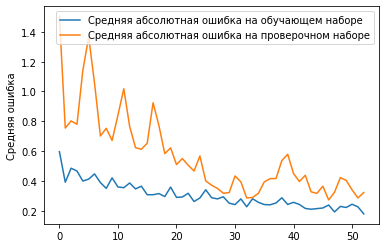

In [37]:
model.set_weights(ww)
history = model.fit(x=train_x,y=train_y, epochs=54,\
                       batch_size=None, validation_data=(test_x, test_y), verbose=1)
predVal = model.predict(test_x).flatten()
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()


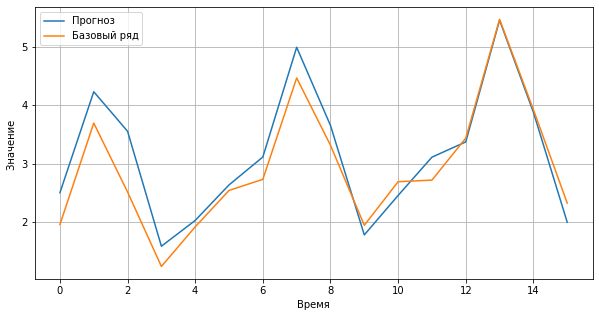

In [38]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

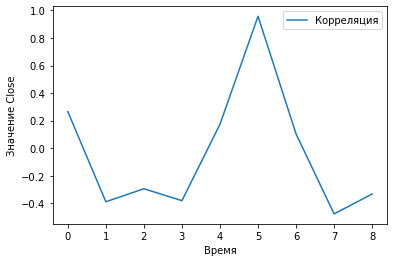

[0.26574731738508117,
 -0.3881640816124091,
 -0.29398759081532944,
 -0.3804066412967868,
 0.17396081429312654,
 0.95749988724763,
 0.10368513323560061,
 -0.47656265440856493,
 -0.331926614437641]

In [55]:
print_corr(test_y,predVal)

Другой вариант сети

In [59]:
%%time
N=300
# res_model = pd.DataFrame()
epochs = 100
batch_size = None
xLen = [2,3,4,5,6,8,10,12]
step=[1,1,1,1,1,2]
# con_n = [6,12,24,30,36,48,64,124]   
# kern = [2,3,4,5,6,7,8,9,10,11,12]
# ps = [2,3,4,5,6,7,8,9,10,11,12]
lstm_n = [12,24,36,48,60,72,80,100,125,150]
d_n_1 = [10,25,35,45,50,60,70,80,90,100,15,200,300,350,400,500]
act_1 = ['relu','relu','softmax','relu','relu','tanh','relu','relu']
dp=[0.1,0.15,0.2,0.2,0.3]


for i in range(N):
    param={}

    param['xLen'] = np.random.choice(xLen)
    param['step'] = np.random.choice(step)
#     param['con_n'] = np.random.choice(con_n)
#     param['kern'] = int(np.random.choice(kern))
#     param['ps'] = int(np.random.choice(ps))
    param['d_n_1'] = np.random.choice(d_n_1)
    param['d_n_2'] = np.random.choice(d_n_1)
    param['act_1'] = np.random.choice(act_1)
    param['act_2'] = np.random.choice(act_1)
    param['lstm_n'] = np.random.choice(lstm_n)
    param['dp'] = np.random.choice(dp)
    
    
    train_x,train_y = get_data(data = train,xLen=param['xLen'],step=param['step'])
    test_x,test_y = get_data(data = valid,xLen=param['xLen'],step=param['step'])
    
    input_1 = Input(shape=(train_x.shape[1:]))
#     z1 = Conv1D(param['con_n'],param['kern'],padding = 'same')(input_1)
# #     z1=MaxPooling1D(pool_size = param['ps'],strides =1,padding = 'same')(z1)
#     z1 = Dropout(param['dp'])(z1)

    x1 = LSTM(param['lstm_n'], return_sequences="True")(input_1)
    x1 = Dropout(param['dp'])(x1)

    x1=Flatten()(x1)
    x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
    x1 = Dropout(param['dp'])(x1)
    x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
    x1 = Dropout(param['dp'])(x1)
    out=Dense(1)(x1)
    model_2 = Model(inputs = input_1,outputs = out,name = f'model_2_{i}')
    model_2.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model_2.get_weights()
    res = testing(model_2,10)
    res['epochs'] = epochs
    res['model'] = model_2.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model

Wall time: 2h 7min 54s


,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,None,100.0,model_56,"{'xLen': 12, 'step': 2, 'con_n': 6, 'kern': 10...",0.406439,0.273122,0.224291,0.052453,0.195145,2.274667
609,None,100.0,model_2_284,"{'xLen': 12, 'step': 2, 'd_n_1': 350, 'd_n_2':...",0.352299,0.273270,0.236713,0.034411,0.119982,2.131655
399,None,100.0,model_2_74,"{'xLen': 12, 'step': 2, 'd_n_1': 400, 'd_n_2':...",0.325821,0.273869,0.242902,0.023464,0.127061,2.112136
327,None,100.0,model_2_2,"{'xLen': 12, 'step': 2, 'd_n_1': 200, 'd_n_2':...",0.495223,0.279124,0.229388,0.074492,0.118537,2.115199
474,None,100.0,model_2_149,"{'xLen': 10, 'step': 1, 'd_n_1': 100, 'd_n_2':...",0.343596,0.286957,0.257464,0.028090,0.139596,2.671010
...,...,...,...,...,...,...,...,...,...,...
483,None,100.0,model_2_158,"{'xLen': 10, 'step': 1, 'd_n_1': 300, 'd_n_2':...",2.695984,2.584174,2.549068,0.041088,0.677983,2.794678
473,None,100.0,model_2_148,"{'xLen': 10, 'step': 1, 'd_n_1': 35, 'd_n_2': ...",2.697026,2.588667,2.561189,0.040045,0.679287,2.586207
322,None,100.0,model_287,"{'xLen': 12, 'step': 1, 'con_n': 64, 'kern': 1...",2.738002,2.613925,2.584534,0.044431,0.635890,2.803186
323,None,100.0,model_267,"{'xLen': 5, 'step': 2, 'con_n': 24, 'kern': 4,...",2.671369,2.634604,2.622767,0.013403,0.761798,2.321911


Возмем за основу model_2_74	. Так как зорошее среднее, минимальное значение res_max и res_std

In [60]:
res_model.iloc[2,3]

{'xLen': 12,
 'step': 2,
 'd_n_1': 400,
 'd_n_2': 300,
 'act_1': 'relu',
 'act_2': 'tanh',
 'lstm_n': 72,
 'dp': 0.2}

In [61]:
%%time
param = res_model.iloc[2,3]
param['xLen'] = np.random.choice(xLen)
param['step'] = np.random.choice(step)
param['d_n_1'] = np.random.choice(d_n_1)
param['d_n_2'] = np.random.choice(d_n_1)
param['act_1'] = np.random.choice(act_1)
param['act_2'] = np.random.choice(act_1)
param['lstm_n'] = np.random.choice(lstm_n)
param['dp'] = np.random.choice(dp)

    
train_x,train_y = get_data(data = train,xLen=param['xLen'],step=param['step'])
test_x,test_y = get_data(data = valid,xLen=param['xLen'],step=param['step'])
    
input_1 = Input(shape=(train_x.shape[1:]))

x1 = LSTM(param['lstm_n'], return_sequences="True")(input_1)
x1 = Dropout(param['dp'])(x1)

x1=Flatten()(x1)
x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
x1 = Dropout(param['dp'])(x1)
x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
x1 = Dropout(param['dp'])(x1)
out=Dense(1)(x1)
model_2_best = Model(inputs = input_1,outputs = out,name = 'model_2_best')
model_2_best.compile(loss="mse", optimizer="adam", metrics=['mae'])
ww= model_2_best.get_weights()

for epochs in [50,70,100,150,200,250]:
    res = testing(model_2_best,50)
    res['epochs'] = epochs
    res['model'] = model_2_best.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model
    

NameError: name 'res_mode' is not defined

In [63]:
res_model[res_model.model=='model_2_best']

,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
629,None,200.0,model_2_best,"{'xLen': 6, 'step': 1, 'd_n_1': 350, 'd_n_2': ...",0.869612,0.620188,0.472057,0.086696,0.215739,4.792010
628,None,150.0,model_2_best,"{'xLen': 6, 'step': 1, 'd_n_1': 350, 'd_n_2': ...",0.829600,0.622360,0.474292,0.092530,0.226902,3.589904
627,None,100.0,model_2_best,"{'xLen': 6, 'step': 1, 'd_n_1': 350, 'd_n_2': ...",0.763615,0.639172,0.479315,0.067219,0.241880,2.440461
630,None,250.0,model_2_best,"{'xLen': 6, 'step': 1, 'd_n_1': 350, 'd_n_2': ...",0.861050,0.663205,0.496852,0.090654,0.204747,5.973870
626,None,70.0,model_2_best,"{'xLen': 6, 'step': 1, 'd_n_1': 350, 'd_n_2': ...",0.883568,0.669466,0.514575,0.096821,0.255669,1.687154
625,None,50.0,model_2_best,"{'xLen': 6, 'step': 1, 'd_n_1': 350, 'd_n_2': ...",0.983883,0.711945,0.501529,0.104075,0.268042,1.257678


Epoch 1/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8023 - mae: 0.7136 - val_loss: 1.7572 - val_mae: 1.0098
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.4140 - mae: 0.5188 - val_loss: 1.7078 - val_mae: 1.1216
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.3276 - mae: 0.4695 - val_loss: 1.4082 - val_mae: 0.8972
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2932 - mae: 0.4323 - val_loss: 2.3515 - val_mae: 1.2328
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3055 - mae: 0.4338 - val_loss: 1.0007 - val_mae: 0.7855
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2534 - mae: 0.3990 - val_loss: 1.0456 - val_mae: 0.7771
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2379 - mae: 0.3858 - val_loss: 1.2942 - val_mae: 0.8803
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2155 - mae: 0.38

3/3 [==============================] - 0s 11ms/step - loss: 0.1212 - mae: 0.2741 - val_loss: 0.9183 - val_mae: 0.7953
Epoch 64/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0946 - mae: 0.2329 - val_loss: 0.7078 - val_mae: 0.6735
Epoch 65/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0990 - mae: 0.2547 - val_loss: 0.4647 - val_mae: 0.5577
Epoch 66/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1071 - mae: 0.2664 - val_loss: 0.4624 - val_mae: 0.5623
Epoch 67/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0964 - mae: 0.2558 - val_loss: 0.8716 - val_mae: 0.7819
Epoch 68/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1281 - mae: 0.2801 - val_loss: 0.7548 - val_mae: 0.7156
Epoch 69/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0967 - mae: 0.2433 - val_loss: 0.4439 - val_mae: 0.5469
Epoch 70/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1190 - mae: 0.2615 - 

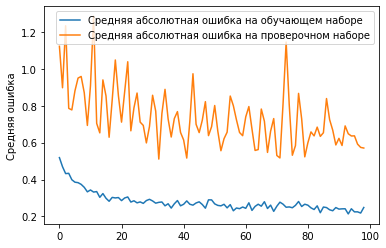

In [73]:
# Обучим лучшую модель
model_2_best.set_weights(ww)
history = model_2_best.fit(x=train_x,y=train_y, epochs=100,\
                       batch_size=None, validation_data=(test_x, test_y), verbose=1)
predVal = model_2_best.predict(test_x).flatten()
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

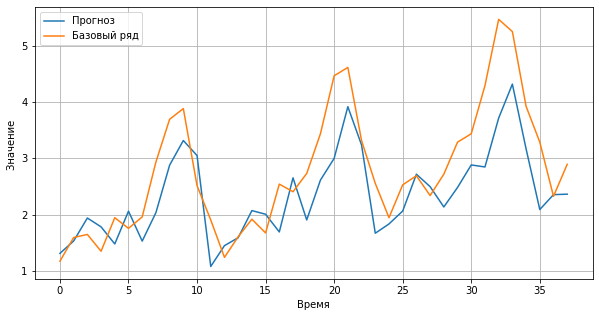

In [74]:
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal, 
         label='Прогноз')
plt.plot(test_y, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

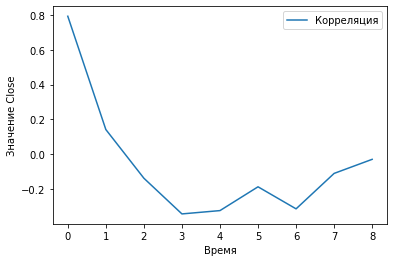

[0.7929025496179798,
 0.14188342061566597,
 -0.13779634810526298,
 -0.3429238193286718,
 -0.32383413890806906,
 -0.18712918678288537,
 -0.31380535676170823,
 -0.11015480925869216,
 -0.029287855290038405]

In [75]:
print_corr(test_y,predVal)

In [80]:
train_x.shape[1]

10

In [ ]:
%%time
N=300
# res_model = pd.DataFrame()
epochs = 100
batch_size = None
xLen = [2,3,4,5,6,8,10,12]
step=[1,1,1,1,1,2]

lstm_n = [12,24,36,48,60,72,80,100,125,150]
d_n_1 = [10,25,35,45,50,60,70,80,90,100,15,200,300,350,400,500]
act_1 = ['relu','relu','softmax','relu','relu','tanh','relu','relu']
dp=[0.1,0.15,0.2,0.2,0.3]


for i in range(N):
    param={}

    param['xLen'] = np.random.choice(xLen)
    param['step'] = np.random.choice(step)
    param['d_n_1'] = np.random.choice(d_n_1)
    param['d_n_2'] = np.random.choice(d_n_1)
    param['act_1'] = np.random.choice(act_1)
    param['act_2'] = np.random.choice(act_1)
    param['lstm_n'] = np.random.choice(lstm_n)
    param['dp'] = np.random.choice(dp)
    param['d_n_3'] = np.random.choice(d_n_1)
    param['act_3'] = np.random.choice(act_1)
    
    
    train_x,train_y = get_data(data = train,xLen=param['xLen'],step=param['step'])
    test_x,test_y = get_data(data = valid,xLen=param['xLen'],step=param['step'])
    
    input_1 = Input(shape=(train_x.shape[1:]))
    z1 = Dense(param['d_n_3'],activation=param['act_3'])(input_1)
    z1 = Dense(train_x.shape[1],activation='relu')(z1)

    x1 = LSTM(param['lstm_n'], return_sequences="True")(z1)
    x1 = Dropout(param['dp'])(x1)

    x1=Flatten()(x1)
    x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
    x1 = Dropout(param['dp'])(x1)
    x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
    x1 = Dropout(param['dp'])(x1)
    out=Dense(1)(x1)
    model_3 = Model(inputs = input_1,outputs = out,name = f'model_3_{i}')
    model_3.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model_3.get_weights()
    res = testing(model_3,10)
    res['epochs'] = epochs
    res['model'] = model_3.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model

In [83]:
res_model.iloc[-3:]

,batch_size,epochs,model,param,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
628,None,100.0,model_287,"{'xLen': 12, 'step': 1, 'con_n': 64, 'kern': 1...",2.738002,2.613925,2.584534,0.044431,0.635890,2.803186
629,None,100.0,model_267,"{'xLen': 5, 'step': 2, 'con_n': 24, 'kern': 4,...",2.671369,2.634604,2.622767,0.013403,0.761798,2.321911
630,None,100.0,model_234,"{'xLen': 12, 'step': 2, 'con_n': 124, 'kern': ...",2.742931,2.708788,2.666850,0.027804,0.714939,2.355318


А теперь самую простую модель

In [ ]:
%%time
N=300
# res_model = pd.DataFrame()
epochs = 50
batch_size = None
xLen = [2,3,4,5,6,8,10,12]
step=[1,1,1,1,1,2]

lstm_n = [12,24,36,48,60,72,80,100,125,150]
d_n_1 = [10,25,35,45,50,60,70,80,90,100,15,200,300,350,400,500]
act_1 = ['relu','relu','softmax','relu','relu','tanh','relu','relu']
dp=[0.1,0.15,0.2,0.2,0.3]


for i in range(N):
    param={}

    param['xLen'] = np.random.choice(xLen)
    param['step'] = np.random.choice(step)
    param['d_n_1'] = np.random.choice(d_n_1)
    param['d_n_2'] = np.random.choice(d_n_1)
    param['act_1'] = np.random.choice(act_1)
    param['act_2'] = np.random.choice(act_1)
    param['lstm_n'] = np.random.choice(lstm_n)
    param['dp'] = np.random.choice(dp)
    param['d_n_3'] = np.random.choice(d_n_1)
    param['act_3'] = np.random.choice(act_1)
    
    
    train_x,train_y = get_data(data = train,xLen=param['xLen'],step=param['step'])
    test_x,test_y = get_data(data = valid,xLen=param['xLen'],step=param['step'])
    
    input_1 = Input(shape=(train_x.shape[1:]))
    z1 = Dense(param['d_n_3'],activation=param['act_3'])(input_1)
    z1 = Dense(train_x.shape[1],activation='relu')(z1)

    x1 = LSTM(param['lstm_n'], return_sequences="True")(z1)
    x1 = Dropout(param['dp'])(x1)

    x1=Flatten()(x1)
    x1 = Dense(param['d_n_1'],activation=param['act_1'])(x1)
    x1 = Dropout(param['dp'])(x1)
    x1 = Dense(param['d_n_2'],activation=param['act_2'])(x1)
    x1 = Dropout(param['dp'])(x1)
    out=Dense(1)(x1)
    model_3 = Model(inputs = input_1,outputs = out,name = f'model_3_{i}')
    model_3.compile(loss="mse", optimizer="adam", metrics=['mae'])

    ww= model_3.get_weights()
    res = testing(model_3,10)
    res['epochs'] = epochs
    res['model'] = model_3.name
    res['param'] = param
    res_model=res_model.append(res,ignore_index=True)
res_model.sort_values(by='res_mean',inplace=True)
res_model